In [93]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
# Load the dataset

data = pd.read_csv("credit.csv")

In [94]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [95]:
import pandas as pd
from pandas.plotting import andrews_curves
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

# Assuming 'data' is your DataFrame containing the features and target
X = data.drop(columns=['Class'])
y = data['Class']

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

logreg = LogisticRegression(random_state=42, max_iter=4000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")


Confusion Matrix:
[[56832    20]
 [   42    68]]
False Positives: 20
False Negatives: 42


## You can see above that there are 45 false negatives. 45 people got away. I will reduced this significantly by using statistical techniques 

## First I will use under sampling becaus the dataset is really unbalanced. You can see the unbalance below

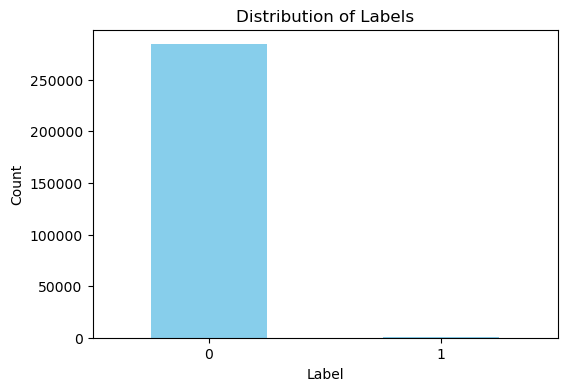

In [97]:
import matplotlib.pyplot as plt

label_counts = y.value_counts()

plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [98]:
## Below I am using randoundersampler to fix the label balance 

In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# First, split your dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)  


## Below you see that I did 50:50 sampling

In [100]:
resampled_label_counts = y_train_res.value_counts(normalize=True) * 100

print("Percentage of labels in the resampled training set:")
print(resampled_label_counts)


Percentage of labels in the resampled training set:
Class
0    50.0
1    50.0
Name: proportion, dtype: float64


In [101]:
print(X_train_scaled.shape)
y_train_res.shape

(788, 30)


(788,)

## After undersampling. I will apply regularization. I will do gridsearch to find best regularizaiton parameter  

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np

regularization_strengths = [0.01, 0.1,.5, 1,2]
penalties = ['l1', 'l2']

results = []

for penalty in penalties:
    for C in regularization_strengths:
        solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
        logreg = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=42, max_iter=10000)
        logreg.fit(X_train_scaled, y_train_res)
        y_pred = logreg.predict(X_test_scaled)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Store only false positives and false negatives
        results.append((penalty, C, fp, fn))
        
        print(f"Penalty: {penalty}, C: {C}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print("---------------------------------------------------")


min_fn_result = min(results, key=lambda x: x[3])
print(f"Best configuration with minimum false negatives: Penalty={min_fn_result[0]}, C={min_fn_result[1]}")
print("Confusion Matrix of the best configuration:")
print(min_fn_result[2])


Penalty: l1, C: 0.01
False Positives: 136
False Negatives: 19
---------------------------------------------------
Penalty: l1, C: 0.1
False Positives: 819
False Negatives: 12
---------------------------------------------------
Penalty: l1, C: 0.5
False Positives: 1525
False Negatives: 8
---------------------------------------------------
Penalty: l1, C: 1
False Positives: 1711
False Negatives: 8
---------------------------------------------------
Penalty: l1, C: 2
False Positives: 1943
False Negatives: 8
---------------------------------------------------
Penalty: l2, C: 0.01
False Positives: 284
False Negatives: 17
---------------------------------------------------
Penalty: l2, C: 0.1
False Positives: 989
False Negatives: 10
---------------------------------------------------
Penalty: l2, C: 0.5
False Positives: 1416
False Negatives: 8
---------------------------------------------------
Penalty: l2, C: 1
False Positives: 1632
False Negatives: 8
---------------------------------------

## Below, I will show how catboost reduced false negatives even further. from the original 45 FN to 6 FN

In [103]:
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

catboost = CatBoostClassifier(random_state=42, iterations=1000, verbose=0)
catboost.fit(X_train_scaled, y_train_res)

y_pred = catboost.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")


False Positives: 1275
False Negatives: 6


## Xgboost does better but it sacrifices false positives too much 

In [104]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Initialize and train XGBoost classifier with regularization
xgb_classifier = xgb.XGBClassifier(random_state=42, n_estimators=200, verbosity=0,
                                   reg_lambda=.5)  # Adjust regularization strength as needed

xgb_classifier.fit(X_train_scaled, y_train_res)

y_pred = xgb_classifier.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")


False Positives: 2289
False Negatives: 5


## Randomforest does just as well as catboost. Better than Xgboost

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

rf_classifier = RandomForestClassifier(random_state=42)

param_grid = {'n_estimators': [50, 100, 200, 300, 400, 500]}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_res)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test_scaled)

## Confusion code

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")


False Positives: 1394
False Negatives: 6


## Below I try SVM and knn with different parameters 

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# Apply Random Under Sampling
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Initialize KNN classifier
knn_classifier = KNeighborsClassifier()

# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [2, 3, 5, 7],
    'weights': ['uniform', 'distance']
}

# Initialize SVM classifier
svm_classifier = SVC()

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1,.5, 1, 2, 4],
    'kernel': ['linear', 'rbf']
}

# Initialize GridSearchCV for KNN
grid_search_knn = GridSearchCV(knn_classifier, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)

# Initialize GridSearchCV for SVM
grid_search_svm = GridSearchCV(svm_classifier, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV for KNN
grid_search_knn.fit(X_train_scaled, y_train_res)

# Fit GridSearchCV for SVM
grid_search_svm.fit(X_train_scaled, y_train_res)

# Get best parameters and best estimators for both classifiers
best_params_knn = grid_search_knn.best_params_
best_knn = grid_search_knn.best_estimator_

best_params_svm = grid_search_svm.best_params_
best_svm = grid_search_svm.best_estimator_

# Predict on the test set using the best estimators
y_pred_knn = best_knn.predict(X_test_scaled)
y_pred_svm = best_svm.predict(X_test_scaled)

# Evaluate the performance of KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)
tn_knn, fp_knn, fn_knn, tp_knn = cm_knn.ravel()

print("KNN Classifier:")
print(f"False Positives: {fp_knn}")
print(f"False Negatives: {fn_knn}")

# Evaluate the performance of SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)
tn_svm, fp_svm, fn_svm, tp_svm = cm_svm.ravel()

print("SVM Classifier:")
print(f"False Positives: {fp_svm}")
print(f"False Negatives: {fn_svm}")


KNN Classifier:
False Positives: 1367
False Negatives: 15
SVM Classifier:
False Positives: 1907
False Negatives: 7
